# Basics of Mobile Robotics: Project - Part Global Nav


# Author : PB

In [2]:
import numpy as np
import control as ct
import control.optimal as opt
import matplotlib.pyplot as plt

## GLOBAL NAVIGATION IMPLEMENTATION

I decided to develop and test my global navigation on this notebook before implementing it in the folder

In [223]:
# USE OF MPC

#	X    -----------------      u       ---------
#	---> | MPC Regulator |------------> | Plant |----------> Output
#	|    -----------------              ---------   |
#	|           ^                                   |
#	|           | (xs, us)                          |
#	|           |                                   |
#	|           |       ------------                |
#	|           --------| target   |<----------------
#	|                   | selector |<-- reference   |
#	|                   ------------                |
#	|                                               |
#	-------------------------------------------------

Initial parameters

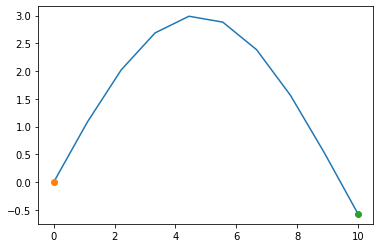

In [216]:
Tf = 10
min_velocity = 8
max_velocity = 12
min_deviation_phi = -2
max_deviation_phi = 2

tps = np.linspace(0, Tf, Tf)
plt.plot(tps, 3*np.sin(tps/3))

x0 = [0., 0., 0.]; u0 = [np.sqrt((tps[1]-tps[0])**2 + (np.sin(tps[1])-np.sin(tps[0]))**2), (tps[1]-tps[0])/Tf]
xf = [tps[-1], 3*np.sin(tps[-1]/3), 0.]; uf = [0., 0.]

plt.plot(x0[0], x0[1], marker="o")
plt.plot(xf[0], xf[1], marker="o")

Useful functions

In [185]:
def vehicle_update(t, x, u, params):
    # Get the parameters for the model
    l = params.get('wheelbase', 3.)         # vehicle wheelbase
    phimax = params.get('maxsteer', 0.5)    # max steering angle (rad)
    
    # Saturate the steering input
    phi = np.clip(u[1], min_deviation_phi, max_deviation_phi)

    # Return the derivative of the state
    return np.array([
        np.cos(x[2]) * u[0],            # xdot = cos(theta) v
        np.sin(x[2]) * u[0],            # ydot = sin(theta) v
        (u[0] / l) * np.tan(phi)        # thdot = v/l tan(phi)
    ])



def vehicle_output(t, x, u, params):
    return x                            # return x, y, theta (full state)

# Define the vehicle steering dynamics as an input/output system
vehicle = ct.NonlinearIOSystem(
    vehicle_update, vehicle_output, states=3, name='vehicle',
    inputs=('v', 'phi'), outputs=('x', 'y', 'theta'))

Q = np.diag([0, 0, 0.1])          # don't turn too sharply
R = np.diag([1, 1])               # keep inputs small
P = np.diag([1000, 1000, 1000])   # get close to final point

First iteration test

Summary statistics:
* Cost function calls: 986
* System simulations: 986
* Final cost: 4.8977042933806825


c:\Users\paul\AppData\Local\Programs\Python\Python310\lib\site-packages\control\optimal.py:862: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Desired error not necessarily achieved due to precision loss.
  warnings.warn(


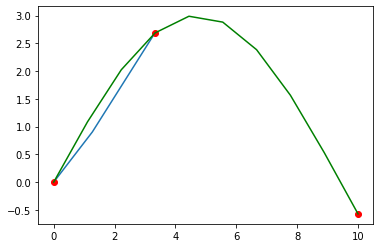

In [221]:
LengthHorizon = 3

xgoal = [tps[LengthHorizon], 3*np.sin(tps[LengthHorizon]/3), (tps[LengthHorizon]-tps[LengthHorizon-1])/Tf]
traj_cost = opt.quadratic_cost(vehicle, Q, R, x0=xgoal, u0=u0)
term_cost = opt.quadratic_cost(vehicle, P, 0, x0=xgoal)
    
#constraints = [ opt.input_range_constraint(vehicle, [min_velocity, min_deviation_phi], [max_velocity, max_deviation_phi]) ]
constraints = []  

horizon = np.linspace(0, LengthHorizon, LengthHorizon, endpoint=True)
result = opt.solve_ocp(vehicle, horizon, x0, traj_cost, constraints,terminal_cost=term_cost, initial_guess=u0, log=False)

# Simulate the system dynamics (open loop)
resp = ct.input_output_response(
    vehicle, horizon, result.inputs, x0,
    t_eval=np.linspace(0, LengthHorizon, LengthHorizon))
t, y, u = resp.time, resp.outputs, resp.inputs

# Plot
plt.plot(y[0], y[1])
plt.plot(x0[0], x0[1], 'ro', xgoal[0], xgoal[1], 'ro', xf[0], xf[1], 'ro')
plt.plot(tps, 3*np.sin(tps/3), 'g')

plt.show()


Optimization loop

In [222]:
# still working on this part

Xfinal = np.zeros((Tf,2))

LengthHorizon = 3
eps = 0.5

xcurrent = x0
ite = 0
while (abs(xcurrent[0]-xf[0])>eps and abs(xcurrent[1]-xf[1])>eps) and ite<15:

    if (ite+LengthHorizon<Tf):
        index = ite+LengthHorizon
    else:
        index = Tf

    xgoal = [tps[index], 3*np.sin(tps[index]/3), (tps[index]-tps[index-1])/Tf]
    traj_cost = opt.quadratic_cost(vehicle, Q, R, xcurrent=xgoal, u0=u0)
    term_cost = opt.quadratic_cost(vehicle, P, 0, xcurrent=xgoal)
    
    #constraints = [ opt.input_range_constraint(vehicle, [min_velocity, min_deviation_phi], [max_velocity, max_deviation_phi]) ]
    constraints = []  

    horizon = np.linspace(0, LengthHorizon, LengthHorizon, endpoint=True)
    result = opt.solve_ocp(vehicle, horizon, xcurrent[ite], traj_cost, constraints,terminal_cost=term_cost, initial_guess=u0)

    # Simulate the system dynamics (open loop)
    resp = ct.input_output_response(
        vehicle, horizon, result.inputs, x0,
        t_eval=np.linspace(0, LengthHorizon, LengthHorizon))
    t, y, u = resp.time, resp.outputs, resp.inputs
    
    Xfinal[ite,:] = y

    ite += 1

TypeError: quadratic_cost() got an unexpected keyword argument 'xcurrent'

Final plot